# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
# data processing
import math
import json
from multiprocessing import Pool, cpu_count
from multiprocessing.dummy import Pool as ThreadPool 
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import *

In [2]:
# google
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from operator import itemgetter

In [3]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

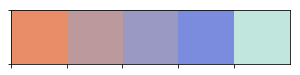

In [4]:
# defining colors
COLORS = {
    'ORANGE': '#E88D67',
    'PINK': '#BB999C',
    'VIOLET': '#9999C3',
    'BLUE': '#7B8CDE',
    'GREEN': '#C0E6DE'
}

# palette
sns.set_palette(COLORS.values())
sns.palplot(sns.color_palette())
sns.set(font_scale=1.5, style='whitegrid')

## Setup Google Sheets Auth

In [5]:
# setup connection
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('credential.json', scope)
gc = gspread.authorize(credentials)

# Load in data

## Log Data from LES

In [6]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
end_time = '2018-03-20 05:00:00'
print('Study Length: {}'.format(datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')))

Study Length: 14 days, 23:00:00


In [7]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in collection_list:
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

def load_data_parallel(url):
    return load_data(url, header, data, start_time, end_time)

In [8]:
# fetch log data
urls = [url_4x, url_opp_location, url_opp_distance]
pool = ThreadPool(cpu_count())
results = pool.map(load_data_parallel, urls)
pool.close()
pool.join()

data_4x = results[0]
data_opp_loc = results[1]
data_opp_dist = results[2]

## Post-Study Survey Data

In [9]:
def load_post_study_data(url, new_col_names=[]):
    """
    Loads in and returns post-study as a Pandas DataFrame with header remapped according to values above.
    
    Inputs:
        url (string): url of spreadsheet to load in
        new_col_names (list): list of strings for new column names
    
    Returns:
        (DataFrame): Pandas DataFrame with header remapped above
    """
    url_connection = gc.open_by_url(url)
    raw_data = url_connection.get_worksheet(0).get_all_values()
    
    output_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
    if len(new_col_names) > 0:
        output_df.columns = new_col_names

    return output_df

In [10]:
# setup 4X post-survey data
url_4x = 'https://docs.google.com/spreadsheets/d/1rCH32DdAfnOSoe-qNIQgO7rQei2VATHxLlGfP0bCNg8/edit#gid=339656711'
cols_4x = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altprefs',
    'expand_info_disruption',
    'expand_info_number_notif',
    'exploit_atloc',
    'exploit_enroute',
    'exploit_disruption',
    'miscellaneous'
]
post_study_4x = load_post_study_data(url_4x, new_col_names=cols_4x)
post_study_4x.to_csv('./analysis/post_study_4x.csv', index=False)
post_study_4x.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,expand_info_going,expand_info_going_notgo,expand_info_notuseful,expand_info_altprefs,expand_info_disruption,expand_info_number_notif,exploit_atloc,exploit_enroute,exploit_disruption,miscellaneous
0,3/18/2018 23:17:30,allisonsun2018@u.northwestern.edu,Allison Sun,3: Neutral,"2: Rarely, in less than 10% of the notifications",4: Somewhat likely,I liked being notified for free food in Ford a...,Always responded to the notifications for Ford...,Can't think of any instances when I didn't res...,2: Rarely disruptive,Only went the free food places in ford because...,N/A,N/A,Coffee shops that I frequent more like Peets a...,2: Rarely disruptive,2: Fewer than I would have liked,N/A,N/A,0: N/A,


In [11]:
# setup 4X post-survey data
url_opp_loc = 'https://docs.google.com/spreadsheets/d/15x6yST-eJh1azQJxQRtkOb37E397RJhzG-3CDbPCflk/edit#gid=1062479755'
cols_opp_loc = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'miscellaneous'
]
post_study_opp_loc = load_post_study_data(url_opp_loc, new_col_names=cols_opp_loc)
post_study_opp_loc.to_csv('./analysis/post_study_opp_loc.csv', index=False)
post_study_opp_loc.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,miscellaneous
0,3/19/2018 18:45:44,abigailpetrotta2021@u.northwestern.edu,Abigail Petrotta,4: Valuable,"2: Rarely, in less than 10% of the notifications",4: Somewhat likely,"Super easy to use, did not like how there was ...",I wanted to help this study,I did not see the notification until later,"1: Not disruptive, easy to do and continue on ...",


In [12]:
# setup 4X post-survey data
url_opp_dist = 'https://docs.google.com/spreadsheets/d/1YJVo7ouNklEXb1DLZlzGttoaTDk-z2WJxVPIRmB5hyw/edit#gid=446248525'
cols_opp_dist = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_noinfo',
    'expand_noinfo_disruption',
    'expand_noinfo_number_notif',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altpref',
    'expand_info_disruption',
    'expand_info_number_notif',
    'miscellaneous'
]
post_study_opp_dist = load_post_study_data(url_opp_dist, new_col_names=cols_opp_dist)
post_study_opp_dist.to_csv('./analysis/post_study_opp_dist.csv', index=False)
post_study_opp_dist.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,expand_noinfo,expand_noinfo_disruption,expand_noinfo_number_notif,expand_info_going,expand_info_going_notgo,expand_info_notuseful,expand_info_altpref,expand_info_disruption,expand_info_number_notif,miscellaneous
0,3/19/2018 9:16:56,allyodo13@gmail.com,Ally O'Donnell,2: Invaluable,"3: Occasionally, in about 30% of the notificat...",1: Not likely,The most frustrating thing was when the app wo...,It wasn't an inconvenience for me to respond. ...,I was in a rush to class or I didn't see the n...,3: Occasionally disruptive,I just didn't want to go. I never went to look...,"5: A great deal disruptive, I had to stop what...",5: Far more than I would have liked,I already had a routine in mind. I never went ...,No,"I never got notifications for free pizza, whic...","Places specifically in tech, lesser known loca...",3: Occasionally disruptive,4: More than I would have liked,


# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [13]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='Missed Notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'Dismissed Notification'
    atloc.loc[atloc['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [14]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='Missed Notification')
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)
    
    # remap columns
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'Dismissed Notification'

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [15]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    enrouteresp.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId']],
                            how='left', on=['enRouteLocationId', 'vendorId'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='Missed Notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'Dismissed Notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    enroute.loc[enroute['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [16]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [17]:
location_scaffolds = {}
for index, row in data_4x['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']

## 4X Log Data Setup

In [18]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [19]:
serverlog_4x = deepcopy(data_4x['ServerLog'])
deadapp_notify_4x = get_dead_apps(serverlog_4x)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_4x[-1]),
                                                          '\n'.join(deadapp_notify_4x[-1])))

flattened_deadapps_4x = reduce(lambda x, y: x + y, deadapp_notify_4x, [])
Counter(flattened_deadapps_4x)

Last dead apps notified (count = 15): 
0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC
B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10
4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F
F57CB6D4-09B3-4796-AE91-2F31BADEE832
79CCD350-AAC5-4586-A6FC-1948B49A4B10
95674A2B-6954-49C6-9456-A7F865CE686E
E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30
B0686F52-978C-4925-A466-E7A6A765B258
53F61BDE-FFC0-476A-AF7B-D592F4155AC8
D3D3D1E2-1F39-4AB8-917D-52876AA63830
E78771C1-08B3-4483-99D8-4A081E98DABC
C89DDEDC-F459-40BA-8073-EAFF7FC53C34
FDEFE367-350F-4B8B-898E-710487D51BF4
8617CA10-E2AD-4420-B92B-AF170930FDB1
203FE158-68A6-496F-B72E-274A4417983A


Counter({'0E322CAE-1091-4C9D-835F-24C36AA2A4D7': 4,
         '0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC': 11,
         '163E0EF0-E16E-4D06-9037-69000FF4F199': 1,
         '203FE158-68A6-496F-B72E-274A4417983A': 3,
         '3508DCCF-243B-4B23-AC41-C514EF1671E8': 1,
         '437A2325-CA4D-4426-9F1A-F89E412A00AC': 6,
         '4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F': 15,
         '4D412B42-A080-49E7-A091-74C42D2778BF': 2,
         '4DFAD945-87C6-4219-B237-7345E7600105': 4,
         '53F61BDE-FFC0-476A-AF7B-D592F4155AC8': 15,
         '6E3825DB-09C2-4C6C-B3BC-62DBFFD6F7EE': 1,
         '79CCD350-AAC5-4586-A6FC-1948B49A4B10': 14,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 7,
         '95674A2B-6954-49C6-9456-A7F865CE686E': 15,
         '9859FB99-038D-4BB8-B8FB-30470D06B57E': 3,
         'A0288977-976D-4831-93D4-8472FC842621': 6,
         'B0686F52-978C-4925-A466-E7A6A765B258': 15,
         'B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10': 15,
         'C89DDEDC-F459-40BA-8073-EAFF7FC53C34': 15,
    

In [20]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])
enroutelocations_4x = deepcopy(data_4x['EnRouteLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

In [21]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

In [22]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded']] # 4X Only: remove cases without info

In [23]:
# TODO: check if all 4X people actually did give more data
atdist_4x

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp
8,qEEQc1qnPp,4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F,cE9k7N4F4I,166.639624,38.746021,gym,Blomquist,300,geofence trip,True,-21600,1520265048,No. This info is useful but I have to be somew...,1520265139
9,qEEQc1qnPp,D3D3D1E2-1F39-4AB8-917D-52876AA63830,cE9k7N4F4I,318.252963,289.163286,gym,Blomquist,300,geofence trip,True,-21600,1520268642,No. This info is useful but I have to be somew...,1520268688
35,GQylbLtAkk,53F61BDE-FFC0-476A-AF7B-D592F4155AC8,3xNa2peiRk,320.117338,55.390454,workspace,Main 1South,300,geofence trip,True,-21600,1520288357,Missed Notification,-1
42,2GVlen6bc2,3508DCCF-243B-4B23-AC41-C514EF1671E8,,311.772067,2.243515,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520290652,No. This info is useful but I have to be somew...,1520290683
43,nERqAcXEd5,A42EDE26-8487-44FC-955D-944FAD8D1D4C,,305.861387,8.917406,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520279924,No. This info isn't useful to me.,1520280394
44,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282261,"Yes! This info is useful, I'm going now.",1520282274
45,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282453,"Yes! This info is useful, I'm going now.",1520282580
46,bHLI27bIch,E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30,,315.158147,46.561554,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520353798,Missed Notification,-1
47,ZmQ7UclGyT,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,,322.905405,6.901818,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520375088,No. This info is useful but I have to be somew...,1520375501
48,8WM9wgAXDX,FDEFE367-350F-4B8B-898E-710487D51BF4,Y6oyD2IvMA,338.848665,298.279215,workspace,Mudd Common Area (outside library),300,geofence trip,True,-21600,1520375551,No. This info isn't useful to me.,1520377116


In [24]:
# merged data from with all EnRoute data
enroute_4x = get_merged_en_route(deepcopy(enroutelocations_4x),
                                 deepcopy(enroutenotif_4x),
                                 deepcopy(enrouteresp_4x))

## Opp at Distance Log Data Setup

In [25]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [26]:
serverlog_opp_dist = deepcopy(data_opp_dist['ServerLog'])
deadapp_notify_opp_dist = get_dead_apps(serverlog_opp_dist)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_dist[-1]),
                                                          '\n'.join(deadapp_notify_opp_dist[-1])))

flattened_deadapps_opp_dist = reduce(lambda x, y: x + y, deadapp_notify_opp_dist, [])
Counter(flattened_deadapps_opp_dist)

Last dead apps notified (count = 20): 
D1338E4F-A39D-4D48-9E13-0C9535B27DA4
EA5C3169-A161-4909-8FFE-E7AD76A3CD3F
A376DA22-0D0E-4E61-B554-BB011B20C205
64F010DE-D544-4F83-944A-6551C9998E91
8EE01978-8AD4-410E-9F5F-B20E93875ACD
F8875879-3920-4880-B7A2-61AAA67957FD
2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A
B2F59A67-D682-4367-AE96-632E3EA75D06
23D16DA8-4AEB-4CED-80D6-9EE3B5F05C6B
35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3
6E39791E-43F3-48BD-88AD-1E50EAB27E2B
B3342593-A72F-4715-B728-F82852432A4C
2C92D8B2-025C-4D03-A52E-1C82AD780228
F9E6F4F2-061C-4AD2-9EDD-5B448A2ACFD2
F19C76DD-FFDA-4875-9397-45B93E152ED3
A8BDA823-DB7E-47E0-9B75-DE998A68756A
3153A147-D884-43E2-B37F-028A3C7A1F4C
EDB4A5DC-C43D-4064-BBB9-2C6BE19BF819
1F8A8384-CF46-42E2-AECF-1427DB1CE7AF
BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7


Counter({'086AFB2A-294D-495E-9BD2-19B22C179C00': 4,
         '1F8A8384-CF46-42E2-AECF-1427DB1CE7AF': 15,
         '23D16DA8-4AEB-4CED-80D6-9EE3B5F05C6B': 4,
         '282EBA67-4C26-4BAF-AC6F-5785BA07B7DF': 1,
         '2C92D8B2-025C-4D03-A52E-1C82AD780228': 15,
         '2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A': 15,
         '3153A147-D884-43E2-B37F-028A3C7A1F4C': 7,
         '35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3': 14,
         '64C31BCA-FB95-4D89-9774-0DDE7FC1B63F': 8,
         '64F010DE-D544-4F83-944A-6551C9998E91': 15,
         '6E39791E-43F3-48BD-88AD-1E50EAB27E2B': 15,
         '8EE01978-8AD4-410E-9F5F-B20E93875ACD': 15,
         'A376DA22-0D0E-4E61-B554-BB011B20C205': 13,
         'A8BDA823-DB7E-47E0-9B75-DE998A68756A': 2,
         'ABC10D33-2533-4FE5-9DBB-59BAAFD6E15C': 2,
         'B2F59A67-D682-4367-AE96-632E3EA75D06': 15,
         'B3342593-A72F-4715-B728-F82852432A4C': 15,
         'B40B49C0-B139-49B3-A36D-52EEB62932FF': 8,
         'BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7': 13,
 

In [27]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

In [28]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))

In [29]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))

## Opp at Location Log Data Setup

In [30]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [31]:
serverlog_opp_loc = deepcopy(data_opp_loc['ServerLog'])
deadapp_notify_opp_loc = get_dead_apps(serverlog_opp_loc)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_loc[-1]),
                                                          '\n'.join(deadapp_notify_opp_loc[-1])))

flattened_deadapps_opp_loc = reduce(lambda x, y: x + y, deadapp_notify_opp_loc, [])
Counter(flattened_deadapps_opp_loc)

Last dead apps notified (count = 16): 
91237D64-CE23-46F5-B622-59FC927DA643
9C4CB624-70D2-400C-900B-119803C5FEAA
B2ABB039-3AD4-4C69-BC1E-3917A843EA9A
566EBB40-146B-4C6C-BA3E-49E5FB735E87
4D948452-9913-4A94-BFF2-67039C8B86AE
BA6D41A7-29EB-4757-9470-CDE37EBA69A3
4D09BB7A-921E-43C3-B2A9-E65784776B57
280C2DFC-22B7-436F-B964-F4D7A4329F05
44152338-7684-47F8-B18B-0CB1D965A8C3
C62677A5-66FF-42F4-8F06-DD63BF8ADCB7
316B7E89-E085-44B3-ACD0-EAA3E4B815C5
FFC6D8AB-EA05-46D6-9701-68A49BB2A556
9EF07688-0D43-4E38-970A-F09D2D4CAF36
9E65FEFD-F7CA-4647-A3B8-8C35E9D00699
A7345311-5DC8-4C0A-B882-FD78ED62AE1B
15DF333A-774A-492A-9E83-7FAD841F2B65


Counter({'00E9FFC5-887D-4EE4-BA21-B6667A693609': 1,
         '15DF333A-774A-492A-9E83-7FAD841F2B65': 15,
         '280C2DFC-22B7-436F-B964-F4D7A4329F05': 4,
         '316B7E89-E085-44B3-ACD0-EAA3E4B815C5': 13,
         '3D0D2A1E-46B1-47E4-8380-2D215C5B1733': 1,
         '44152338-7684-47F8-B18B-0CB1D965A8C3': 13,
         '45EFF419-5C9C-42FB-99D4-810D55F48A29': 2,
         '46628AEB-1D72-49EC-B816-66C14FE381CA': 2,
         '46EA14E9-CC43-45CD-8858-7244118F61F1': 1,
         '4D09BB7A-921E-43C3-B2A9-E65784776B57': 15,
         '4D948452-9913-4A94-BFF2-67039C8B86AE': 15,
         '4EA8A226-13F4-4015-BEAF-657D948E8839': 8,
         '566EBB40-146B-4C6C-BA3E-49E5FB735E87': 15,
         '5FB3D5F4-4EF7-47BC-B7C3-43F25C78C954': 3,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 1,
         '91237D64-CE23-46F5-B622-59FC927DA643': 14,
         '98896F25-9344-4D6E-A726-C271E534DF7C': 2,
         '9A40E531-C24E-42A8-9A9A-D464F13B126B': 5,
         '9C4CB624-70D2-400C-900B-119803C5FEAA': 1,
     

In [32]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

In [33]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))

# Preference-User Counts 
Determine how many users could potentially be notified, given the preferences they specified. We want to see how different our ordering vs. the ordering that may be determined by preference might be.

In [34]:
def compute_preference_count(pref_dict, users):
    """
    Counts the number of people who would prefer each piece of information in the scaffold.
    
    Input:
        pref_dict (dict): dictionary of location type : questions that contains scaffold structure
        users (DataFrame): users and their preferences
    
    Return:
        (dict) pref_dict with counts for each question
    """
    for index, row in users.iterrows():
        curr_preferences = row['preferences']
        
        for location_type, location_prefs in curr_preferences.items():
            for question, pref_array in location_prefs.items():
                if pref_dict[location_type][question] == '':
                    pref_dict[location_type][question] = 1 if len(pref_array) > 0 else 0
                else: 
                    pref_dict[location_type][question] += 1 if len(pref_array) > 0 else 0
    
    return pref_dict

In [35]:
compute_preference_count(deepcopy(location_scaffolds), users_4x)

{'coffeeshop': {'privateseating': 22,
  'privateseatingoutlets': 18,
  'privateseatingwindows': 11,
  'sharedseating': 15,
  'sharedseatingoutlets': 12,
  'sharedseatingwindows': 8},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 11,
  'freeweightsbenches': 6,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 7,
  'treadmills': 17},
 'workspace': {'privateseating': 26,
  'privateseatingoutlets': 19,
  'sharedseating': 11,
  'sharedseatingoutlets': 9,
  'whiteboards': 10,
  'whiteboardsmarkers': 3}}

In [36]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_dist)

{'coffeeshop': {'privateseating': 26,
  'privateseatingoutlets': 20,
  'privateseatingwindows': 10,
  'sharedseating': 17,
  'sharedseatingoutlets': 13,
  'sharedseatingwindows': 6},
 'freefood': {'foodtype': 29, 'stillleft': 0},
 'gym': {'ellipticals': 8,
  'freeweights': 10,
  'freeweightsbenches': 3,
  'freeweightssquatracks': 7,
  'stretch': 9,
  'stretchmats': 6,
  'stretchrollers': 2,
  'treadmills': 14},
 'workspace': {'privateseating': 23,
  'privateseatingoutlets': 17,
  'sharedseating': 12,
  'sharedseatingoutlets': 8,
  'whiteboards': 6,
  'whiteboardsmarkers': 2}}

In [37]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_loc)

{'coffeeshop': {'privateseating': 25,
  'privateseatingoutlets': 22,
  'privateseatingwindows': 10,
  'sharedseating': 10,
  'sharedseatingoutlets': 8,
  'sharedseatingwindows': 5},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 9,
  'freeweightsbenches': 5,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 1,
  'treadmills': 16},
 'workspace': {'privateseating': 27,
  'privateseatingoutlets': 21,
  'sharedseating': 16,
  'sharedseatingoutlets': 13,
  'whiteboards': 10,
  'whiteboardsmarkers': 5}}

# Data Dashboard
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper, but the core purpose of this section is for monitoring the study.

In [38]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for location_col and response_col to aggregate on.
        location_col (string): location column to aggregate on (e.g. locationType, locationName)
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1)
    
    return combined_byloc

In [39]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['Total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

In [40]:
def compute_valid_count_prop_byuser(data, users, user_col, response_col, valid_responses):
    """
    Computes and returns a groupby DataFrame with counts and proportions of valid responses, by user.
    
    Input:
        data (DataFrame): must include columns for user_col and response_col to aggregate on.
        users (DataFrame): users to include for no responses
        user_col (string): user column to aggregate on (e.g. vendorId)
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
        valid_responses (list of strings): list of valid responses to include in final output
    
    Output:
        (groupby DataFrame): aggregated data when valid response exists, by user
    """
    count_byuser = data.groupby([user_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byuser = count_byuser.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byuser, prop_byuser], axis=1).reset_index()
    
    # isolate only valid responses and return
    combined_byloc = combined_byloc[combined_byloc[response_col].isin(valid_responses)].reset_index(drop=True)
    
    # include all people in dataframe
    combined_byloc = combined_byloc.merge(users[['objectId', 'vendorId']], how='right')
    del combined_byloc['objectId']
    
    # fill blanks
    combined_byloc.fillna(value={
        response_col: 'No Responses',
        'count': 0,
        'count_proportion': 0.0
    }, inplace=True)
    
    return combined_byloc

## 4X: At Location

In [41]:
atloc_4x_count_prop_byloc = compute_count_prop_byloc(atloc_4x, 'locationType', 'remappedResponses')
atloc_4x_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response     64         26.890756
             Dismissed Notification       4          1.680672
             Missed Notification         78         32.773109
             Valid Response              92         38.655462
freefood     "I don't know" Response     13         41.935484
             Dismissed Notification       1          3.225806
             Missed Notification          4         12.903226
             Valid Response              13         41.935484
gym          "I don't know" Response      7          7.526882
             Dismissed Notification       2          2.150538
             Missed Notification         34         36.559140
             Valid Response              50         53.763441
workspace    "I don't know" Response      4          3.389831
             Dismissed Notification       1          0.847458
             Missed Notification         42         35.593220
             Valid Response              71         60.169492

In [42]:
atloc_4x_count_prop_overall = compute_count_prop_overall(atloc_4x, 'remappedResponses')
atloc_4x_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",88,18.333333
1,Dismissed Notification,8,1.666667
2,Missed Notification,158,32.916667
3,Valid Response,226,47.083333
4,Total,480,100.000000


In [43]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 31


In [44]:
atloc_4x_valid_responses = ['Valid Response']
atloc_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                   atloc_4x_valid_responses)
atloc_4x_valid_count_prop_byuser.head()

,vendorId,remappedResponses,count,count_proportion
0,0E322CAE-1091-4C9D-835F-24C36AA2A4D7,Valid Response,4.0,11.764706
1,0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC,Valid Response,11.0,40.740741
2,163E0EF0-E16E-4D06-9037-69000FF4F199,Valid Response,10.0,58.823529
3,203FE158-68A6-496F-B72E-274A4417983A,Valid Response,2.0,20.000000
4,3508DCCF-243B-4B23-AC41-C514EF1671E8,Valid Response,3.0,33.333333


## 4X: At Distance (with info)

In [45]:
atdist_4x_count_prop_byloc = compute_count_prop_byloc(atdist_4x, 'locationType', 'emaResponse')
atdist_4x_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   Missed Notification                                    11   
             No. Other reason.                                       1   
             No. This info is useful but I have to be somewh...     14   
             No. This info isn't useful to me.                       5   
             Yes. This info is useful but I'm already going ...      1   
freefood     Missed Notification                                     8   
             No. Other reason.                                       2   
             No. This info is useful but I have to be somewh...      5   
             No. This info isn't useful to me.                       4   
             Yes! This info is useful, I'm going now.                3   
             Yes. This info is useful but I'm already going ...      1   
gym          Missed Notification                                    29   
             No. This info is useful but I have to be somewh...     23   
             No. This info isn't useful to me.                      14   
             Yes! This info is useful, I'm going now.                1   
workspace    Dismissed Notification                                  1   
             Missed Notification                                    14   
             No. This info is useful but I have to be somewh...     15   
             No. This info isn't useful to me.                       5   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   Missed Notification                                        34.375000  
             No. Other reason.                                           3.125000  
             No. This info is useful but I have to be somewh...         43.750000  
             No. This info isn't useful to me.                          15.625000  
             Yes. This info is useful but I'm already going ...          3.125000  
freefood     Missed Notification                                        34.782609  
             No. Other reason.                                           8.695652  
             No. This info is useful but I have to be somewh...         21.739130  
             No. This info isn't useful to me.                          17.391304  
             Yes! This info is useful, I'm going now.                   13.043478  
             Yes. This info is useful but I'm already going ...          4.347826  
gym          Missed Notification                                        43.283582  
             No. This info is useful but I have to be somewh...         34.328358  
             No. This info isn't useful to me.                          20.895522  
             Yes! This info is useful, I'm going now.                    1.492537  
workspace    Dismissed Notification                                      2.857143  
             Missed Notification                                        40.000000  
             No. This info is useful but I have to be somewh...         42.857143  
             No. This info isn't useful to me.                          14.285714

In [46]:
atdist_4x_count_prop_overall = compute_count_prop_overall(atdist_4x, 'emaResponse')
atdist_4x_count_prop_overall

,emaResponse,count,percentage
0,Dismissed Notification,1,0.636943
1,Missed Notification,62,39.490446
2,No. Other reason.,3,1.910828
3,No. This info is useful but I have to be somew...,57,36.305732
4,No. This info isn't useful to me.,28,17.834395
5,"Yes! This info is useful, I'm going now.",4,2.547771
6,Yes. This info is useful but I'm already going...,2,1.273885
7,Total,157,100.000000


In [47]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 30


In [48]:
atdist_4x_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_4x, users_4x, 'vendorId', 'emaResponse',
                                                                    atdist_4x_valid_responses)
atdist_4x_valid_count_prop_byuser.head()

,vendorId,emaResponse,count,count_proportion
0,3950424A-7986-4771-B867-E4A5624D00ED,"Yes! This info is useful, I'm going now.",1.0,20.000000
1,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,"Yes! This info is useful, I'm going now.",1.0,14.285714
2,F869C396-591A-4F19-895B-5E5871924B45,"Yes! This info is useful, I'm going now.",2.0,25.000000
3,203FE158-68A6-496F-B72E-274A4417983A,No Responses,0.0,0.000000
4,8617CA10-E2AD-4420-B92B-AF170930FDB1,No Responses,0.0,0.000000


## 4X: En Route

In [49]:
enroute_4x_count_prop_byloc = compute_count_prop_byloc(enroute_4x, 'locationType', 'remappedResponses')
enroute_4x_count_prop_byloc

,,count,count_proportion
locationType,remappedResponses,,
parkingspace,Valid Response,1,100.0


In [50]:
enroute_4x_count_prop_overall = compute_count_prop_overall(enroute_4x, 'remappedResponses')
enroute_4x_count_prop_overall

,remappedResponses,count,percentage
0,Valid Response,1,100.0
1,Total,1,100.0


In [51]:
print('Unique number of users notified: {}'.format(len(enroute_4x['vendorId'].unique())))

Unique number of users notified: 1


In [52]:
enroute_4x_valid_responses = ['Valid Response']
enroute_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(enroute_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                     enroute_4x_valid_responses)
enroute_4x_valid_count_prop_byuser.head()

,vendorId,remappedResponses,count,count_proportion
0,F869C396-591A-4F19-895B-5E5871924B45,Valid Response,1.0,100.0
1,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,No Responses,0.0,0.0
2,203FE158-68A6-496F-B72E-274A4417983A,No Responses,0.0,0.0
3,8617CA10-E2AD-4420-B92B-AF170930FDB1,No Responses,0.0,0.0
4,FDEFE367-350F-4B8B-898E-710487D51BF4,No Responses,0.0,0.0


## Opp at Distance: At Location

In [53]:
atloc_opp_dist_count_prop_byloc = compute_count_prop_byloc(atloc_opp_dist, 'locationType', 'remappedResponses')
atloc_opp_dist_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response     22         11.000000
             Dismissed Notification       8          4.000000
             Missed Notification         86         43.000000
             Valid Response              84         42.000000
freefood     "I don't know" Response      3         13.043478
             Dismissed Notification       1          4.347826
             Missed Notification          8         34.782609
             Valid Response              11         47.826087
gym          "I don't know" Response      5         10.416667
             Dismissed Notification       1          2.083333
             Missed Notification         18         37.500000
             Valid Response              24         50.000000
workspace    "I don't know" Response      8          6.106870
             Dismissed Notification       1          0.763359
             Missed Notification         39         29.770992
             Valid Response              83         63.358779

In [54]:
atloc_opp_dist_count_prop_overall = compute_count_prop_overall(atloc_opp_dist, 'remappedResponses')
atloc_opp_dist_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",38,9.452736
1,Dismissed Notification,11,2.736318
2,Missed Notification,151,37.562189
3,Valid Response,202,50.248756
4,Total,402,100.000000


In [55]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 31


In [56]:
atloc_opp_dist_valid_responses = ['Valid Response']
atloc_opp_dist_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_dist, users_opp_dist, 'vendorId',
                                                                         'remappedResponses', atloc_opp_dist_valid_responses)
atloc_opp_dist_valid_count_prop_byuser.head()

,vendorId,remappedResponses,count,count_proportion
0,01A01759-AFFD-46F4-8667-0EC396F804D7,Valid Response,22.0,91.666667
1,086AFB2A-294D-495E-9BD2-19B22C179C00,Valid Response,3.0,75.000000
2,282EBA67-4C26-4BAF-AC6F-5785BA07B7DF,Valid Response,5.0,55.555556
3,2C92D8B2-025C-4D03-A52E-1C82AD780228,Valid Response,3.0,11.111111
4,2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A,Valid Response,3.0,42.857143


## Opp at Distance: At Distance (with info)

In [57]:
atdist_opp_dist_info_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_info_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   Missed Notification                                    21   
             No. This info is useful but I have to be somewh...     10   
             No. This info isn't useful to me.                       4   
             Yes! This info is useful, I'm going now.                1   
freefood     Missed Notification                                     3   
             No. This info is useful but I have to be somewh...      2   
             Yes! This info is useful, I'm going now.                2   
             Yes. This info is useful but I'm already going ...      1   
gym          Missed Notification                                     2   
             No. This info is useful but I have to be somewh...      1   
workspace    Missed Notification                                    10   
             No. This info is useful but I have to be somewh...     16   
             No. This info isn't useful to me.                       3   
             Yes! This info is useful, I'm going now.                1   
             Yes. This info is useful but I'm already going ...      2   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   Missed Notification                                        58.333333  
             No. This info is useful but I have to be somewh...         27.777778  
             No. This info isn't useful to me.                          11.111111  
             Yes! This info is useful, I'm going now.                    2.777778  
freefood     Missed Notification                                        37.500000  
             No. This info is useful but I have to be somewh...         25.000000  
             Yes! This info is useful, I'm going now.                   25.000000  
             Yes. This info is useful but I'm already going ...         12.500000  
gym          Missed Notification                                        66.666667  
             No. This info is useful but I have to be somewh...         33.333333  
workspace    Missed Notification                                        31.250000  
             No. This info is useful but I have to be somewh...         50.000000  
             No. This info isn't useful to me.                           9.375000  
             Yes! This info is useful, I'm going now.                    3.125000  
             Yes. This info is useful but I'm already going ...          6.250000

In [58]:
atdist_opp_dist_info_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_info_count_prop_overall

,emaResponse,count,percentage
0,Missed Notification,36,45.569620
1,No. This info is useful but I have to be somew...,29,36.708861
2,No. This info isn't useful to me.,7,8.860759
3,"Yes! This info is useful, I'm going now.",4,5.063291
4,Yes. This info is useful but I'm already going...,3,3.797468
5,Total,79,100.000000


In [59]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 26


In [60]:
atdist_opp_dist_info_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_opp_dist_info_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_info_valid_responses)
atdist_opp_dist_info_valid_count_prop_byuser.head()

,vendorId,emaResponse,count,count_proportion
0,086AFB2A-294D-495E-9BD2-19B22C179C00,"Yes! This info is useful, I'm going now.",1.0,50.0
1,2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A,"Yes! This info is useful, I'm going now.",1.0,25.0
2,D017ACD7-9AFE-4FB7-B0B2-1B74E57B93F5,"Yes! This info is useful, I'm going now.",1.0,50.0
3,F7ABA648-2424-43E0-A0F8-CE3EE06C492B,No Responses,0.0,0.0
4,8A07FCFF-F609-4DA2-BD9A-81CD0E86A518,No Responses,0.0,0.0


## Opp at Distance: At Distance (without info)

In [61]:
atdist_opp_dist_noinfo_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_noinfo_count_prop_byloc

count  \
locationType emaResponse                                            
coffeeshop   Dismissed Notification                            17   
             Missed Notification                              214   
             No. I don't want to go out of my way there.       72   
             No. Other reason.                                 39   
             Sure! I would be happy to go out of my way!        9   
             Sure, but I was going to walk past it anyway.     17   
freefood     Missed Notification                                2   
             No. I don't want to go out of my way there.        1   
gym          Dismissed Notification                             9   
             Missed Notification                              185   
             No. I don't want to go out of my way there.       97   
             No. Other reason.                                 45   
             Sure! I would be happy to go out of my way!        1   
             Sure, but I was going to walk past it anyway.      3   
workspace    Dismissed Notification                             9   
             Missed Notification                              144   
             No. I don't want to go out of my way there.       58   
             No. Other reason.                                 42   
             Sure! I would be happy to go out of my way!        1   
             Sure, but I was going to walk past it anyway.     15   

                                                            count_proportion  
locationType emaResponse                                                      
coffeeshop   Dismissed Notification                                 4.619565  
             Missed Notification                                   58.152174  
             No. I don't want to go out of my way there.           19.565217  
             No. Other reason.                                     10.597826  
             Sure! I would be happy to go out of my way!            2.445652  
             Sure, but I was going to walk past it anyway.          4.619565  
freefood     Missed Notification                                   66.666667  
             No. I don't want to go out of my way there.           33.333333  
gym          Dismissed Notification                                 2.647059  
             Missed Notification                                   54.411765  
             No. I don't want to go out of my way there.           28.529412  
             No. Other reason.                                     13.235294  
             Sure! I would be happy to go out of my way!            0.294118  
             Sure, but I was going to walk past it anyway.          0.882353  
workspace    Dismissed Notification                                 3.345725  
             Missed Notification                                   53.531599  
             No. I don't want to go out of my way there.           21.561338  
             No. Other reason.                                     15.613383  
             Sure! I would be happy to go out of my way!            0.371747  
             Sure, but I was going to walk past it anyway.          5.576208

In [62]:
atdist_opp_dist_noinfo_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_noinfo_count_prop_overall

,emaResponse,count,percentage
0,Dismissed Notification,35,3.571429
1,Missed Notification,545,55.612245
2,No. I don't want to go out of my way there.,228,23.265306
3,No. Other reason.,126,12.857143
4,Sure! I would be happy to go out of my way!,11,1.122449
5,"Sure, but I was going to walk past it anyway.",35,3.571429
6,Total,980,100.000000


In [63]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 32


In [64]:
atdist_opp_dist_noinfo_valid_responses = ['Sure! I would be happy to go out of my way!']
atdist_opp_dist_noinfo_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[~atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_noinfo_valid_responses)
atdist_opp_dist_noinfo_valid_count_prop_byuser.head()

,vendorId,emaResponse,count,count_proportion
0,086AFB2A-294D-495E-9BD2-19B22C179C00,Sure! I would be happy to go out of my way!,1.0,3.125000
1,1F8A8384-CF46-42E2-AECF-1427DB1CE7AF,Sure! I would be happy to go out of my way!,2.0,13.333333
2,6E39791E-43F3-48BD-88AD-1E50EAB27E2B,Sure! I would be happy to go out of my way!,1.0,2.222222
3,ABC10D33-2533-4FE5-9DBB-59BAAFD6E15C,Sure! I would be happy to go out of my way!,1.0,2.000000
4,B2F59A67-D682-4367-AE96-632E3EA75D06,Sure! I would be happy to go out of my way!,1.0,2.380952


## Opp at Location: At Location

In [65]:
atloc_opp_loc_count_prop_byloc = compute_count_prop_byloc(atloc_opp_loc, 'locationType', 'remappedResponses')
atloc_opp_loc_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response     44         16.058394
             Dismissed Notification      13          4.744526
             Missed Notification         86         31.386861
             Valid Response             131         47.810219
freefood     "I don't know" Response      8         36.363636
             Dismissed Notification       1          4.545455
             Missed Notification          5         22.727273
             Valid Response               8         36.363636
gym          "I don't know" Response      2          4.081633
             Dismissed Notification       2          4.081633
             Missed Notification         21         42.857143
             Valid Response              24         48.979592
workspace    "I don't know" Response      9          4.945055
             Dismissed Notification       5          2.747253
             Missed Notification         50         27.472527
             Valid Response             118         64.835165

In [66]:
atloc_opp_loc_count_prop_overall = compute_count_prop_overall(atloc_opp_loc, 'remappedResponses')
atloc_opp_loc_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",63,11.954459
1,Dismissed Notification,21,3.984820
2,Missed Notification,162,30.740038
3,Valid Response,281,53.320683
4,Total,527,100.000000


In [67]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 32


In [68]:
atloc_opp_loc_valid_responses = ['Valid Response']
atloc_opp_loc_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_loc, users_opp_loc, 'vendorId',
                                                                         'remappedResponses', atloc_opp_loc_valid_responses)
atloc_opp_loc_valid_count_prop_byuser.head()

,vendorId,remappedResponses,count,count_proportion
0,00E9FFC5-887D-4EE4-BA21-B6667A693609,Valid Response,5.0,50.000000
1,280C2DFC-22B7-436F-B964-F4D7A4329F05,Valid Response,7.0,53.846154
2,28A891E8-A5CB-468E-A58A-F21948F3534E,Valid Response,1.0,20.000000
3,316B7E89-E085-44B3-ACD0-EAA3E4B815C5,Valid Response,7.0,36.842105
4,3D0D2A1E-46B1-47E4-8380-2D215C5B1733,Valid Response,15.0,88.235294


# Specific Location View 
This section of the notebook is used to monitor the data coming in from the study, for a specific location. For example, we might want to know how a free food location is doing. 

In [69]:
location_id_4x = 'sNfLGcUBAw'
location_id_opp_dist = 'vYBZxNqfKD'
location_id_opp_loc = 'Ajvw3InHvK'

## 4X: Specific Location View

In [70]:
atloc_4x[atloc_4x['taskLocationId'] == location_id_4x]

,taskLocationId,vendorId,beaconId,distanceToLocation,locationType,locationName,gmtOffset,notificationTimestamp,notificationString,question,response,remappedResponses,responseTimestamp
141,sNfLGcUBAw,61433627-A7DB-4DFC-B135-9D1B0D0ED6D3,,9.015508,freefood,Ford Ground Floor (by the staircase),-21600,1520619193,"Notified for sNfLGcUBAw (42.057016, -87.676649...",foodtype,pizza,Valid Response,1520619756
142,sNfLGcUBAw,F57CB6D4-09B3-4796-AE91-2F31BADEE832,,16.979832,freefood,Ford Ground Floor (by the staircase),-21600,1520621434,"Notified for sNfLGcUBAw (42.057016, -87.676649...",stillleft,yes,Valid Response,1520621592
143,sNfLGcUBAw,A0288977-976D-4831-93D4-8472FC842621,,29.364935,freefood,Ford Ground Floor (by the staircase),-21600,1520629698,"Notified for sNfLGcUBAw (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1520633926
144,sNfLGcUBAw,9859FB99-038D-4BB8-B8FB-30470D06B57E,,6.535848,freefood,Ford Ground Floor (by the staircase),-21600,1520637269,"Notified for sNfLGcUBAw (42.057016, -87.676649...",Missed Notification,Missed Notification,Missed Notification,-1


In [71]:
atdist_4x[atdist_4x['taskLocationId'] == location_id_4x]

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp
99,sNfLGcUBAw,3950424A-7986-4771-B867-E4A5624D00ED,,300.243505,32.281613,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520623394,Missed Notification,-1
100,sNfLGcUBAw,0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC,,211.462153,42.169554,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520626305,No. Other reason.,1520626316
101,sNfLGcUBAw,4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F,,306.880076,30.076641,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520627032,Missed Notification,-1
102,sNfLGcUBAw,F869C396-591A-4F19-895B-5E5871924B45,,284.439683,6.775773,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520628912,No. This info is useful but I have to be somew...,1520629601
103,sNfLGcUBAw,E78771C1-08B3-4483-99D8-4A081E98DABC,,294.210782,102.853852,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520629076,Missed Notification,-1
104,sNfLGcUBAw,95674A2B-6954-49C6-9456-A7F865CE686E,,320.467175,75.285564,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520639312,No. This info is useful but I have to be somew...,1520639320
105,sNfLGcUBAw,9859FB99-038D-4BB8-B8FB-30470D06B57E,,164.535429,267.223445,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520639603,Missed Notification,-1


## Opp at Distance: Specific Location View

In [72]:
atloc_opp_dist[atloc_opp_dist['taskLocationId'] == location_id_opp_dist]

,taskLocationId,vendorId,beaconId,distanceToLocation,locationType,locationName,gmtOffset,notificationTimestamp,notificationString,question,response,remappedResponses,responseTimestamp
118,vYBZxNqfKD,CC2C3B56-3429-41E3-A575-C95B062FA175,,12.454106,freefood,Ford Ground Floor (by the staircase),-21600,1520622603,"Notified for vYBZxNqfKD (42.057016, -87.676649...",foodtype,pizza,Valid Response,1520622640
119,vYBZxNqfKD,2C92D8B2-025C-4D03-A52E-1C82AD780228,,29.597044,freefood,Ford Ground Floor (by the staircase),-21600,1520625595,"Notified for vYBZxNqfKD (42.057016, -87.676649...",Missed Notification,Missed Notification,Missed Notification,-1
120,vYBZxNqfKD,8EE01978-8AD4-410E-9F5F-B20E93875ACD,,29.941434,freefood,Ford Ground Floor (by the staircase),-21600,1520626940,"Notified for vYBZxNqfKD (42.057016, -87.676649...",stillleft,no,Valid Response,1520627869


In [73]:
atdist_opp_dist[atdist_opp_dist['taskLocationId'] == location_id_opp_dist]

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp


## Opp at Location: Specific Location View

In [74]:
atloc_opp_loc[atloc_opp_loc['taskLocationId'] == location_id_opp_loc]

,taskLocationId,vendorId,beaconId,distanceToLocation,locationType,locationName,gmtOffset,notificationTimestamp,notificationString,question,response,remappedResponses,responseTimestamp
170,Ajvw3InHvK,316B7E89-E085-44B3-ACD0-EAA3E4B815C5,,27.729442,freefood,Ford Ground Floor (by the staircase),-21600,1520625074,"Notified for Ajvw3InHvK (42.057016, -87.676649...",foodtype,I don't know,"""I don't know"" Response",1520629506
171,Ajvw3InHvK,9E65FEFD-F7CA-4647-A3B8-8C35E9D00699,,22.260720,freefood,Ford Ground Floor (by the staircase),-21600,1520630824,"Notified for Ajvw3InHvK (42.057016, -87.676649...",Missed Notification,Missed Notification,Missed Notification,-1
172,Ajvw3InHvK,CD759DCB-AA44-4130-A246-703F1AD5DBB9,,11.442867,freefood,Ford Ground Floor (by the staircase),-21600,1520632071,"Notified for Ajvw3InHvK (42.057016, -87.676649...",foodtype,I don't know,"""I don't know"" Response",1520632093


# Paper Tables
This section creates the tables that we used for the CHI'18 version of the LES paper. They, for the most part, will be the final tables included in the paper.

In [75]:
def create_study_table(count_prop_df, location_col, response_col, column_dict, response_list):
    """
    Creates the equivalent table found in the paper using a count_prop table.
    
    Input: 
        count_prop_df (DataFrame): DataFrame with locationType, remappedResponses, count, and count_proportion
        location_col (str): column to get locations for columns (e.g. coffeeshops, freefood, etc.)
        response_col (str): column to get responses for rows (e.g. emaResponses, remappedResponses)
        column_dict (dict): columns to include (i.e. locationTypes) in table with label remaps
        response_list (list of str): responses to copy over to new table (e.g. Missed Notif)
    """
    # add additional columns to beginning of table
    columns = ['Response Type', 'Overall']
    columns += column_dict.keys()
    
    # add total row
    response_types = deepcopy(response_list)
    response_types += ['Total']
    
    # create output DataFrame
    output_dict = {'Response Type': response_types}
    output_df = pd.DataFrame(output_dict)
    
    # populate each cell
    for col in columns:
        # ignore first response type column
        if col == 'Response Type':
            continue

        # get counts for each row)
        for row in response_types: 
            if row != 'Total':
                if col == 'Overall':
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[count_prop_df[response_col] == row, 'count'].sum()
                else:
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[(count_prop_df[location_col] == col) &
                                                                                      (count_prop_df[response_col] == row), 'count'].sum()

        # get total
        output_df.loc[response_types.index('Total'), col] = output_df[0:-1][col].sum()

        # create proportion and save
        epsilon = 0.00000000001
        col_proportions = (100 * output_df[col] / (float(output_df.loc[response_types.index('Total'), col]) + epsilon)).astype(np.double).round(2)
        output_df[col] = col_proportions.astype(str) + '% (' + output_df[col].astype(np.int).astype(str) + ')'
        
    # reorder columns
    output_df.columns = columns
    
    # remap column names
    output_df.rename(columns=column_dict, inplace=True)
    
    return output_df

In [76]:
location_remapping = {'coffeeshop': 'Coffee Shops', 'freefood': 'Free Food', 'gym': 'Gyms', 'workspace': 'Workspaces'}
atloc_response_list = ['Valid Response', '"I don\'t know" Response',
                        'Dismissed Notification', 'Missed Notification']
atdist_info_response_list = ['Yes! This info is useful, I\'m going now.',
                            'Yes. This info is useful but I\'m already going there.',
                            'No. This info is useful but I have to be somewhere.',
                            'No. This info isn\'t useful to me.',
                            'No. Other reason.',
                            'Dismissed Notification',
                            'Missed Notification']
atdist_noinfo_response_list = ['Sure! I would be happy to go out of my way!',
                               'Sure, but I was going to walk past it anyway.',
                               'No. I don\'t want to go out of my way there.',
                               'No. Other reason.',
                               'Dismissed Notification',
                               'Missed Notification']

## Comparing Response Rates: At Location

### 4X Study Table: At Location (eXplore)

In [77]:
atloc_4x_tabledata = atloc_4x_count_prop_byloc.reset_index()
create_study_table(atloc_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,47.08% (226),38.66% (92),41.94% (13),53.76% (50),60.17% (71)
1,"""I don't know"" Response",18.33% (88),26.89% (64),41.94% (13),7.53% (7),3.39% (4)
2,Dismissed Notification,1.67% (8),1.68% (4),3.23% (1),2.15% (2),0.85% (1)
3,Missed Notification,32.92% (158),32.77% (78),12.9% (4),36.56% (34),35.59% (42)
4,Total,100.0% (480),100.0% (238),100.0% (31),100.0% (93),100.0% (118)


### 4X Study Data: At Location (eXploit)

In [78]:
enroute_4x_tabledata = enroute_4x_count_prop_byloc.reset_index()
create_study_table(enroute_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
1,"""I don't know"" Response",0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
4,Total,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)


### Opp at Distance Study Table: At Location

In [79]:
atloc_opp_dist_tabledata = atloc_opp_dist_count_prop_byloc.reset_index()
create_study_table(atloc_opp_dist_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,50.25% (202),42.0% (84),47.83% (11),50.0% (24),63.36% (83)
1,"""I don't know"" Response",9.45% (38),11.0% (22),13.04% (3),10.42% (5),6.11% (8)
2,Dismissed Notification,2.74% (11),4.0% (8),4.35% (1),2.08% (1),0.76% (1)
3,Missed Notification,37.56% (151),43.0% (86),34.78% (8),37.5% (18),29.77% (39)
4,Total,100.0% (402),100.0% (200),100.0% (23),100.0% (48),100.0% (131)


### Opp at Location Study Table: At Location

In [80]:
atloc_opp_loc_tabledata = atloc_opp_loc_count_prop_byloc.reset_index()
create_study_table(atloc_opp_loc_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,53.32% (281),47.81% (131),36.36% (8),48.98% (24),64.84% (118)
1,"""I don't know"" Response",11.95% (63),16.06% (44),36.36% (8),4.08% (2),4.95% (9)
2,Dismissed Notification,3.98% (21),4.74% (13),4.55% (1),4.08% (2),2.75% (5)
3,Missed Notification,30.74% (162),31.39% (86),22.73% (5),42.86% (21),27.47% (50)
4,Total,100.0% (527),100.0% (274),100.0% (22),100.0% (49),100.0% (182)


## Comparing Response Rates: At Distance

### 4X Study Table: At Distance (eXpand, with info)

In [81]:
atdist_info_4x_tabledata = atdist_4x_count_prop_byloc.reset_index()
create_study_table(atdist_info_4x_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",2.55% (4),0.0% (0),13.04% (3),1.49% (1),0.0% (0)
1,Yes. This info is useful but I'm already going...,1.27% (2),3.12% (1),4.35% (1),0.0% (0),0.0% (0)
2,No. This info is useful but I have to be somew...,36.31% (57),43.75% (14),21.74% (5),34.33% (23),42.86% (15)
3,No. This info isn't useful to me.,17.83% (28),15.62% (5),17.39% (4),20.9% (14),14.29% (5)
4,No. Other reason.,1.91% (3),3.12% (1),8.7% (2),0.0% (0),0.0% (0)
5,Dismissed Notification,0.64% (1),0.0% (0),0.0% (0),0.0% (0),2.86% (1)
6,Missed Notification,39.49% (62),34.37% (11),34.78% (8),43.28% (29),40.0% (14)
7,Total,100.0% (157),100.0% (32),100.0% (23),100.0% (67),100.0% (35)


### Opp at Distance Study Table: At Distance (with info)

In [82]:
atdist_info_opp_dist_tabledata = atdist_opp_dist_info_count_prop_byloc.reset_index()
create_study_table(atdist_info_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",5.06% (4),2.78% (1),25.0% (2),0.0% (0),3.12% (1)
1,Yes. This info is useful but I'm already going...,3.8% (3),0.0% (0),12.5% (1),0.0% (0),6.25% (2)
2,No. This info is useful but I have to be somew...,36.71% (29),27.78% (10),25.0% (2),33.33% (1),50.0% (16)
3,No. This info isn't useful to me.,8.86% (7),11.11% (4),0.0% (0),0.0% (0),9.37% (3)
4,No. Other reason.,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
5,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
6,Missed Notification,45.57% (36),58.33% (21),37.5% (3),66.67% (2),31.25% (10)
7,Total,100.0% (79),100.0% (36),100.0% (8),100.0% (3),100.0% (32)


### Opp at Distance Study Table: At Distance (without info)

In [83]:
atdist_noinfo_opp_dist_tabledata = atdist_opp_dist_noinfo_count_prop_byloc.reset_index()
create_study_table(atdist_noinfo_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_noinfo_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Sure! I would be happy to go out of my way!,1.12% (11),2.45% (9),0.0% (0),0.29% (1),0.37% (1)
1,"Sure, but I was going to walk past it anyway.",3.57% (35),4.62% (17),0.0% (0),0.88% (3),5.58% (15)
2,No. I don't want to go out of my way there.,23.27% (228),19.57% (72),33.33% (1),28.53% (97),21.56% (58)
3,No. Other reason.,12.86% (126),10.6% (39),0.0% (0),13.24% (45),15.61% (42)
4,Dismissed Notification,3.57% (35),4.62% (17),0.0% (0),2.65% (9),3.35% (9)
5,Missed Notification,55.61% (545),58.15% (214),66.67% (2),54.41% (185),53.53% (144)
6,Total,100.0% (980),100.0% (368),100.0% (3),100.0% (340),100.0% (269)


# Graphs
This section creates some visualizations of the above data. Some will be used in the final paper, 

## Self-Reported Disruption

In [84]:
replacement_dict = {
    '1: Very invaluable': 1,
    '2: Invaluable': 2,
    '3: Neutral': 3,
    '4: Valuable': 4,
    '5: Very valuable': 5,
    '1: Never': 1,
    '2: Rarely, in less than 10% of the notifications': 2,
    '3: Occasionally, in about 30% of the notifications': 3,
    '4: Sometimes, in about 50% of the notifications': 4,
    '5: Frequently, in about 70% of the notifications': 5,
    '6: Usually, in about 90% of the notifications': 6,
    '7: Every time I was notified': 7,
    '1: Not likely': 1,
    '2: Somewhat unlikely': 2,
    '3: Neutral': 3,
    '4: Somewhat likely': 4,
    '5: Very likely': 5,
    '1: Not disruptive, easy to do and continue on with my routine': 1,
    '2: Rarely disruptive': 2,
    '3: Occasionally disruptive': 3,
    '4: Moderately disruptive': 4,
    '5: A great deal disruptive, I had to stop what I was doing to answer': 5,
    '0: N/A': 0,
    '1: Far fewer than I would have liked': 1,
    '2: Fewer than I would have liked': 2,
    '3: About correct for the number I would have liked': 3,
    '4: More than I would have liked': 4,
    '5: Far more than I would have liked': 5,
    '': -1
}

post_study_4x.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_loc.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_dist.replace(to_replace=replacement_dict, inplace=True)

# rescale disruption to be between 1-5
post_study_4x['overall_disruption'] = (2/3) * post_study_4x['overall_disruption'] + (1/3)
post_study_opp_loc['overall_disruption'] = (2/3) * post_study_opp_loc['overall_disruption'] + (1/3)
post_study_opp_dist['overall_disruption'] = (2/3) * post_study_opp_dist['overall_disruption'] + (1/3)

In [85]:
def create_boxplot_df(condition, df):
    """
    Creates a simple melted DF with a condition column, and a column for each attribute (value, disruption, future use, etc) to be plotted.
    
    Inputs:
        condition (string): name of condition
        df (DataFrame): current data
    
    Returns:
        (DataFrame): simplified DataFrame ready for concating and plotting
    """
    return pd.DataFrame({'condition': condition, 'value': df['overall_value'], 'disruption': df['overall_disruption'], 'future use': df['future_use']}).melt(id_vars=['condition'])

plot_melted_dfs = [
    create_boxplot_df('Opp at Location', post_study_opp_loc),
    create_boxplot_df('4X', post_study_4x),
    create_boxplot_df('Opp at Distance', post_study_opp_dist)
]
disruption_plot_data = pd.concat(plot_melted_dfs)
disruption_plot_data = disruption_plot_data[disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0.5,1,'Disruption, Value, and Likeliness to Use in Future by Condition \n 5-Point Likert Scale')

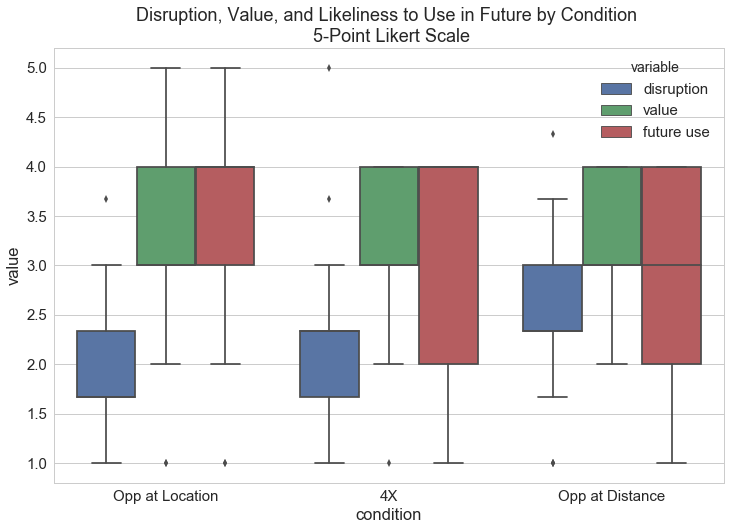

In [86]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=disruption_plot_data,
                 hue_order=['disruption', 'value', 'future use'])
ax.set_title('Disruption, Value, and Likeliness to Use in Future by Condition \n 5-Point Likert Scale')

## Data vs. Pickup Rate vs. Disruption

In [87]:
combined_plot_df = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Location',
        '4X',
        'Opp at Distance',
        'Opp at Distance',
        '4X',
        'Opp at Distance',
        'Opp at Location'
    ],
    'variable': [
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (without Info) \n 300m Away',
        'Mean Self-Reported Disruption \n 5-Point Likert Scale',
        'Mean Self-Reported Disruption \n 5-Point Likert Scale',
        'Mean Self-Reported Disruption \n 5-Point Likert Scale'
    ],
    'value': [
        float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
        post_study_4x['overall_disruption'].mean(),
        post_study_opp_dist['overall_disruption'].mean(),
        post_study_opp_loc['overall_disruption'].mean()
    ]
})

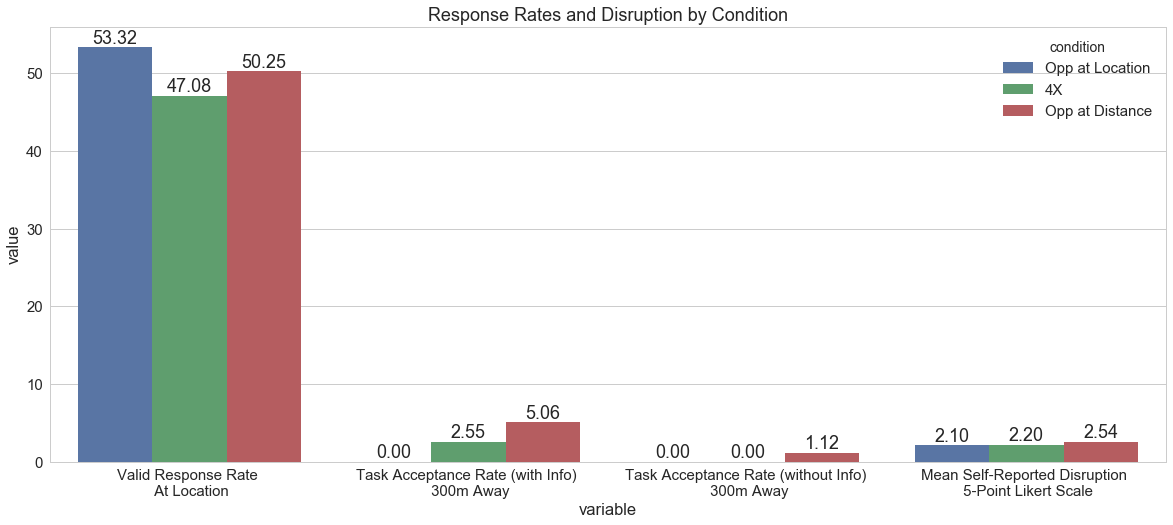

In [88]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=combined_plot_df,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Response Rates and Disruption by Condition')

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        
    ax.text(p.get_x() + p.get_width() /2., height + 0.5, '{:1.2f}'.format(height), ha="center") 

## Info vs No Info Disruption

In [89]:
info_noinfo_plot_melted_dfs = [
    pd.DataFrame({'condition': 'Opp at Location', 'at location': post_study_opp_loc['explore_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': '4X', 'at location': post_study_4x['explore_disruption'], 'info included': post_study_4x['expand_info_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'at location': post_study_opp_dist['explore_disruption'], 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'info included': post_study_opp_dist['expand_info_disruption']}).melt(id_vars=['condition'])
]
info_disruption_plot_data = pd.concat(info_noinfo_plot_melted_dfs)
info_disruption_plot_data = info_disruption_plot_data[info_disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0.5,1,'Disruptiveness of Notification by Notification Type')

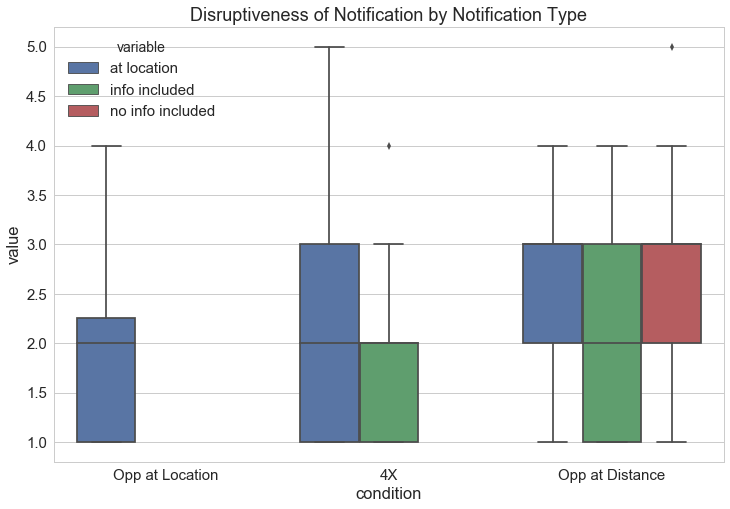

In [90]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_plot_data,
                 hue_order=['at location', 'info included', 'no info included'])
ax.set_title('Disruptiveness of Notification by Notification Type')

In [91]:
info_noinfo_count_plot_melted_dfs = [
    pd.DataFrame({'condition': '4X', 'info included': post_study_4x['expand_info_disruption'], 'info included count': post_study_4x['expand_info_number_notif']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'no info included count': post_study_opp_dist['expand_noinfo_number_notif'],
                  'info included': post_study_opp_dist['expand_info_disruption'], 'info included count': post_study_opp_dist['expand_info_number_notif']}).melt(id_vars=['condition'])
]
info_disruption_count_plot_data = pd.concat(info_noinfo_count_plot_melted_dfs)
info_disruption_count_plot_data = info_disruption_count_plot_data[info_disruption_count_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0.5,1,'Disruptiveness and Desired Count')

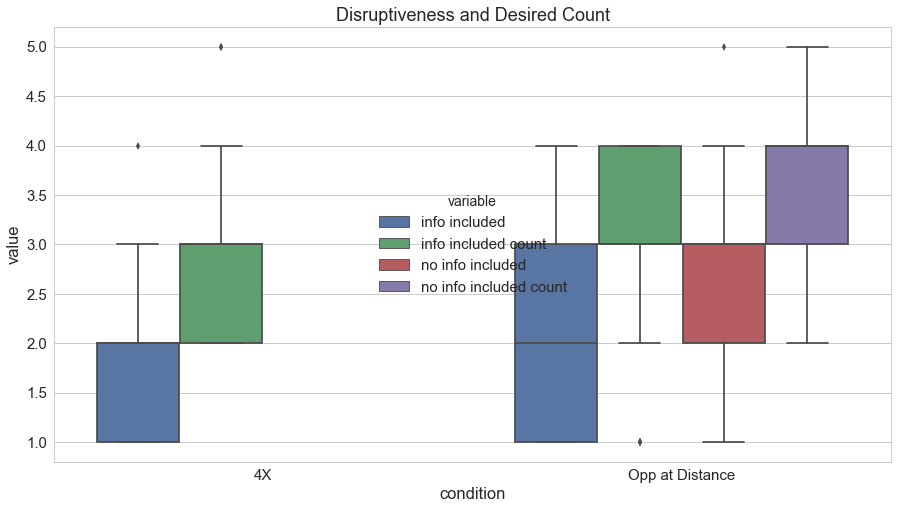

In [93]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_count_plot_data,
                 hue_order=['info included', 'info included count', 'no info included', 'no info included count'])
ax.set_title('Disruptiveness and Desired Count')